In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [3]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

### Your code is here
pipe_lr = Pipeline([('scaler_lr', MinMaxScaler()), ('LR', LogisticRegression())])
pipe_svm = Pipeline([('scaler_svm', MinMaxScaler()), ('SVM', LinearSVC())])



In [11]:
### Обучаем модели на трейне
### Your code is here
pipe_lr.fit(X_train, y_train)
pipe_svm.fit(X_train, y_train)



Pipeline(steps=[('scaler_svm', MinMaxScaler()), ('SVM', LinearSVC())])

Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок [0;1] и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

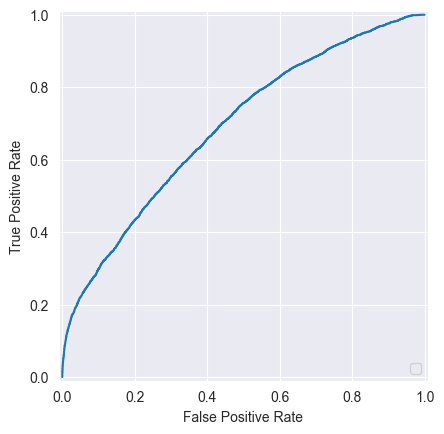

In [30]:
### С изображением рок-кривой для ЛогРега не будет проблем:
### Your code is here
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=fpr_lr, tpr=tpr_lr).plot()


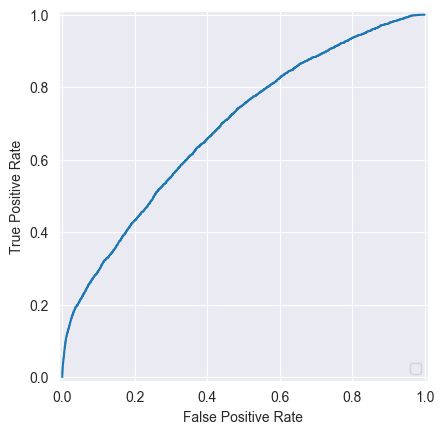

In [31]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

### Your code is here
decision_preds = pipe_svm.decision_function(X_test)
min_pred = min(decision_preds)
max_pred = max(decision_preds)


def est(x, min_p: int, max_p: int):
    if x <= 0:
        return abs(x - min_p) / abs(min_p) * 0.5
    else:
        return abs(x) / abs(max_p) * 0.5 + 0.5

pred_prob_svm = list(est(d, min_pred, max_pred) for d in decision_preds)

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, pred_prob_svm)
RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm).plot()

In [32]:
from sklearn.metrics import auc

### Your code is here
print(f"auc lr {auc(fpr_lr, tpr_lr)}")
print(f"auc svm {auc(fpr_svm, tpr_svm)}")

auc lr 0.688754199644186
auc svm 0.6878082255324112


Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

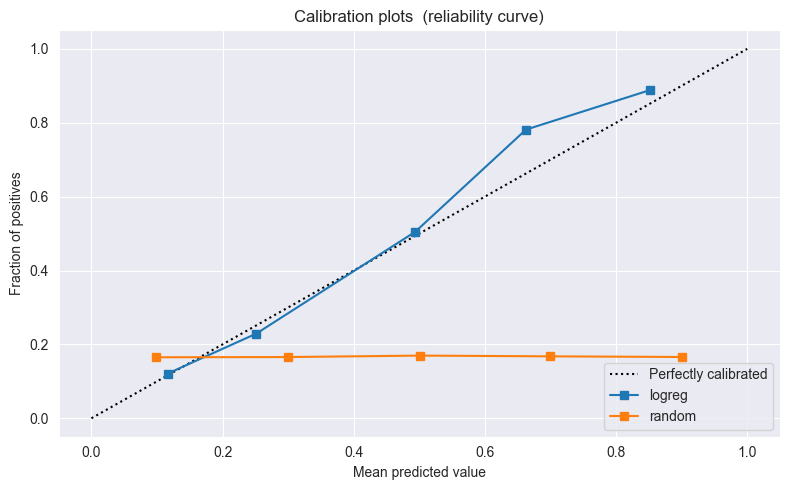

In [41]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
BINS = 5

### Your code is here
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = pipe_lr.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=BINS)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")

### Пусть наши предсказания - случайные, то есть для каждого объекта
### вероятность принадлежности + классу это просто случайное число [0; 1]
prob_pos = np.random.uniform(size=(X_test.shape[0],))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=BINS)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()


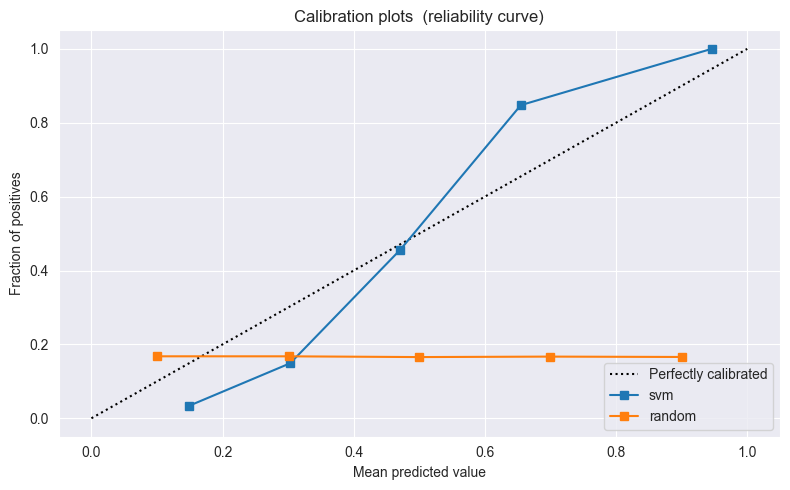

In [42]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = pred_prob_svm
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=BINS)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="svm")

### Пусть наши предсказания - случайные, то есть для каждого объекта
### вероятность принадлежности + классу это просто случайное число [0; 1]
prob_pos = np.random.uniform(size=(X_test.shape[0],))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=BINS)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()



**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [43]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here
calibration_lr = CalibratedClassifierCV(pipe_lr, cv=5, method='sigmoid')
calibration_lr.fit(X_train, y_train)
calibrated_probs_lr = calibration_lr.predict_proba(X_test)[:, 1]

calibration_svm = CalibratedClassifierCV(pipe_svm, cv=5, method='sigmoid')
calibration_svm.fit(X_train, y_train)
calibrated_probs_svm = calibration_svm.predict_proba(X_test)[:, 1]

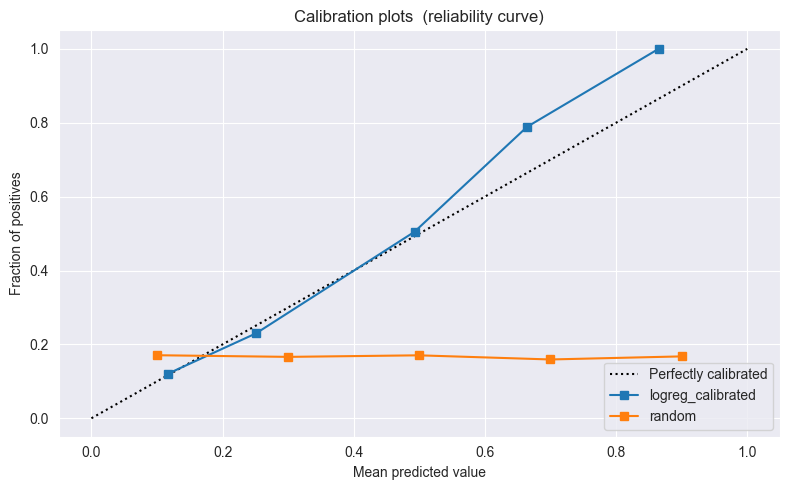

In [44]:
### Your code is here
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = calibrated_probs_lr
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=BINS)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg_calibrated")

### Пусть наши предсказания - случайные, то есть для каждого объекта
### вероятность принадлежности + классу это просто случайное число [0; 1]
prob_pos = np.random.uniform(size=(X_test.shape[0],))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=BINS)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()

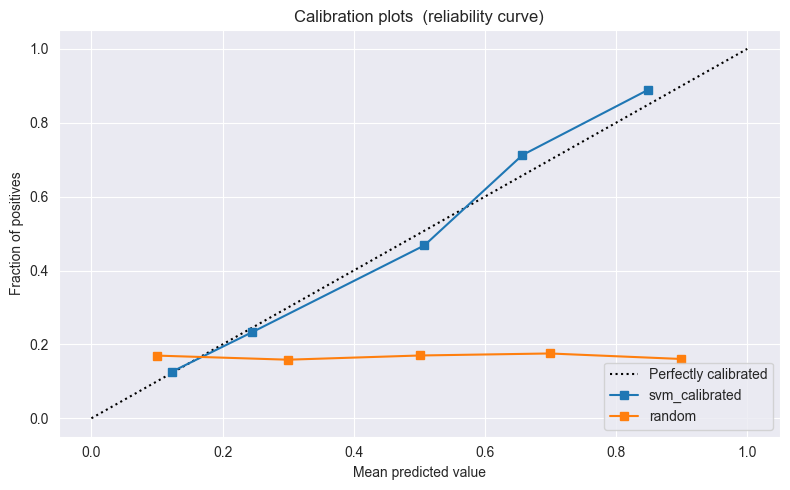

In [45]:
### Новая кривая

### Your code is here
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = calibrated_probs_svm
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=BINS)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="svm_calibrated")

### Пусть наши предсказания - случайные, то есть для каждого объекта
### вероятность принадлежности + классу это просто случайное число [0; 1]
prob_pos = np.random.uniform(size=(X_test.shape[0],))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=BINS)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()

